# **Sequence Tagging** 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from os import path, mkdir
if not path.isdir("data/"):
    mkdir("data/")
if not path.isdir("models/"):
    mkdir("models/")

In [ ]:
!curl https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio  -o data/test.txt
!curl https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio -o data/train.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1139k      0 --:--:-- --:--:-- --:--:-- 1139k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1743k  100 1743k    0     0  3321k      0 --:--:-- --:--:-- --:--:-- 3321k


## Data overview

In [ ]:
def load_data(file):
    '''Helper function to load and transform inputs and labels
    included as a separate function due to NER-specific evaluation needs:
        tensorflow does not have multi-class precision/accuracy as a metric
        so data_y is needed to manually calculate evaluations'''
    file = open(file, 'r')
    sentence, labels = [], []
    data_x, data_y = [], []
    for line in file:
        line = line.strip("\n").split("\t")
        
        # lines with len > 1 are words
        if len(line) > 1:
            sentence.append(line[1])
            labels.append(line[0][2:]) if len(line[0]) > 1 else labels.append(line[0])
        
        # lins with len == 1 are sentence breaks
        if len(line) == 1: 
            data_x.append(' '.join(sentence))
            data_y.append(labels)
            sentence, labels = [], []
    return data_x, data_y

In [ ]:
data_x, data_y = load_data("data/train.txt")

In [ ]:
data_x[:2] # Sequences

['steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies',
 'liza minnelli and joel gray won oscars for their roles in this 1972 movie that follows nightclub entertainers in berlin as the nazis come to power']

In [ ]:
np.reshape(data_y[:2], (1, -1)) # Sequence slots/tags

array([[list(['Actor', 'Actor', 'O', 'O', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Opinion', 'Opinion', 'Opinion', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot']),
        list(['Actor', 'Actor', 'O', 'Actor', 'Actor', 'Award', 'Award', 'O', 'O', 'O', 'O', 'O', 'Year', 'O', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot', 'Plot'])]],
      dtype=object)

### Project params

In [ ]:
all_vocab = []
for sentence in data_x:
  for word in set(sentence.split()):
    all_vocab.append(word)
all_vocab = sorted(set(all_vocab))

In [ ]:
len(all_vocab)

10987

In [ ]:
max_len = max([len(sentence.split()) for sentence in data_x])
max_len

71

In [ ]:
params = {
    #'output_dim' : 20,              # dimension of embeddings       
    'max_vocab' : len(all_vocab)+1, # maximum number of words to embed
    'max_seq_len' : max_len,        # maximum sentence size
    'num_classes' : 13,             # number of unique classes
    'save_dir' : 'models/'          # directory to save hash tables, model weights, etc.
}

### Data Prep

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
def make_tokenizer(file, params = params):
    ''' In order for one hot encoding of words and labels to work, 
    every word and label has to be seen at least once to make a hashing table.
    This function outputs hash tables for the words and the labels
    that can be used to one-hot-encode them in the generator

    # These tokenizers are not zero indexed
    '''
    # Load parameters and data
    max_vocab = params['max_vocab']
    data_x, data_y = load_data(file)
            
    # Use the Keras tokenizer API to generate hashing table for data_x
    tokenizer = Tokenizer(num_words = max_vocab)
    
    tokenizer.fit_on_texts(data_x)
    word_index = tokenizer.word_index
    
    # Flatten data_y and create hashing table using set logic
    data_y_flattened = [item for sublist in data_y for item in sublist]
    
    labels_index = dict([(y, x) for x, y in enumerate(sorted(set(data_y_flattened)))])
    labels = []
    for item in data_y:
        labels.append([labels_index.get(i) for i in item])
    labels_lookup = {v : k for k, v in labels_index.items()} # reverse dictionary for lookup

    return word_index, labels_index, labels_lookup

In [ ]:
word_index, labels_index, labels_lookup = make_tokenizer("data/train.txt")

In [ ]:
def prepare_data(file):
  data_x, data_y = load_data(file)
  # Tokenize
  X = [[word_index.get(word) if word in word_index.keys() else params['max_seq_len']-1 for word in sentence.split()] for sentence in data_x]
  Y = [[labels_index.get(label) for label in sentence] for sentence in data_y]
  # Apply Padding
  X = pad_sequences(maxlen=params['max_seq_len'], sequences=X, padding="post", value=0)
  Y = pad_sequences(maxlen=params['max_seq_len'], sequences=Y, padding="post", value=labels_index.get("O"))
  # Store length
  lengths = [len(sentence.split()) for sentence in data_x]

  return X, Y, lengths

In [ ]:
# Training data
X, Y, lengths = prepare_data("data/train.txt")

In [ ]:
# Testing data
X_test, Y_test, test_lengths = prepare_data("data/test.txt")

Change the labels Y to categorial

In [ ]:
y = [to_categorical(i, num_classes = params['num_classes']) for i in Y]

In [ ]:
y_test = [to_categorical(i, num_classes = params['num_classes']) for i in Y_test]

In [ ]:
# Example sequence output shape
y[0].shape

(71, 13)

## Models

In [ ]:
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras import initializers
from keras.callbacks import ModelCheckpoint

In [ ]:
#!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
from keras_contrib.layers import CRF

#### Approach 1: Bidirectional LSTM-CRF

In [ ]:
def model_biLSTM_CRF(word_embedding_size):
  
  model_input = Input(shape=(params["max_seq_len"],))

  model = Embedding(input_dim = params["max_vocab"],
                    output_dim = word_embedding_size, # Output dimension for embeddings
                    input_length = params["max_seq_len"])(model_input)

  model = Bidirectional(LSTM(units = word_embedding_size,
                              return_sequences = True,
                              dropout = 0.5,
                              recurrent_dropout = 0.5,
                              kernel_initializer = initializers.he_normal()))(model)

  model = LSTM(units = word_embedding_size * 2, 
               return_sequences = True, 
               dropout = 0.5, 
               recurrent_dropout = 0.5, 
               kernel_initializer = initializers.he_normal())(model)

  model = TimeDistributed(Dense(params['num_classes'], activation="relu"))(model)

  crf = CRF(params['num_classes'])
  
  model_output = crf(model)

  model = Model(model_input, model_output)

  model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  model.summary()

  return model


In [ ]:
model1 = model_biLSTM_CRF(word_embedding_size = 150)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 71)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 71, 150)           1648200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 71, 300)           361200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 71, 300)           721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 71, 13)            3913      
_________________________________________________________________
crf_1 (CRF)                  (None, 71, 13)            377       
Total params: 2,734,890
Trainab

In [ ]:
checkpoint = ModelCheckpoint("models/slot_fill_mov_best.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # max -> val_acc
callbacks_list = [checkpoint]

In [ ]:
history = model1.fit(X, np.array(y), batch_size=120, epochs=10, validation_split=0.2, verbose=1, callbacks=callbacks_list)


Train on 6252 samples, validate on 1564 samples
Epoch 1/10
6252/6252 [==============================] - 114s 18ms/step - loss: 0.7575 - crf_viterbi_accuracy: 0.8037 - accuracy: 0.0184 - val_loss: 0.4624 - val_crf_viterbi_accuracy: 0.8708 - val_accuracy: 0.8748

Epoch 00001: val_accuracy improved from -inf to 0.87478, saving model to models/slot_fill_mov_best.hdf5
Epoch 2/10
6252/6252 [==============================] - 111s 18ms/step - loss: 0.3742 - crf_viterbi_accuracy: 0.8994 - accuracy: 0.0184 - val_loss: 0.3568 - val_crf_viterbi_accuracy: 0.8925 - val_accuracy: 0.8952

Epoch 00002: val_accuracy improved from 0.87478 to 0.89521, saving model to models/slot_fill_mov_best.hdf5
Epoch 3/10
6252/6252 [==============================] - 111s 18ms/step - loss: 0.2907 - crf_viterbi_accuracy: 0.9160 - accuracy: 0.0184 - val_loss: 0.3099 - val_crf_viterbi_accuracy: 0.8968 - val_accuracy: 0.8972

Epoch 00003: val_accuracy improved from 0.89521 to 0.89719, saving model to models/slot_fill_mov_b

In [ ]:
hist_pd = pd.DataFrame(history.history)

In [ ]:
hist_pd

,val_loss,val_crf_viterbi_accuracy,val_accuracy,loss,crf_viterbi_accuracy,accuracy
0,0.462432,0.870783,0.874779,0.757535,0.803731,0.018403
1,0.356757,0.892480,0.895213,0.374178,0.899358,0.018403
2,0.309853,0.896756,0.897194,0.290689,0.915971,0.018403
3,0.254667,0.912249,0.914097,0.244214,0.923729,0.018403
4,0.204268,0.931397,0.933621,0.199451,0.936901,0.018403
5,0.167365,0.941642,0.945148,0.161268,0.949852,0.018403
6,0.148690,0.949673,0.951686,0.134987,0.956914,0.018403
7,0.135273,0.951543,0.953694,0.115622,0.962475,0.018403
8,0.124093,0.955382,0.957035,0.101165,0.966042,0.018403
9,0.118056,0.956749,0.958242,0.088747,0.968441,0.018403


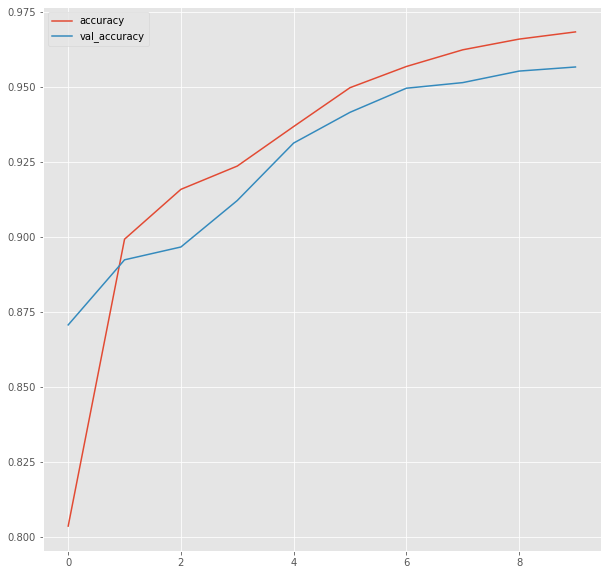

In [ ]:
plt.style.use("ggplot")

plt.figure(figsize=(10, 10))
plt.plot(history.history["crf_viterbi_accuracy"], label='accuracy')
plt.plot(history.history["val_crf_viterbi_accuracy"], label='val_accuracy')
plt.legend()
plt.show()

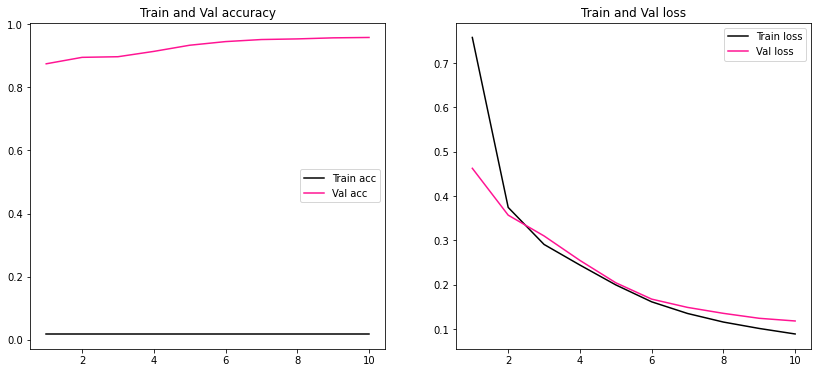

In [ ]:
def plot_performance(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']  
    val_accuracy = history.history['val_accuracy']
    
    x_axis_vals = range(1, len(accuracy) + 1)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis_vals, accuracy, 'black', label='Train acc')
    plt.plot(x_axis_vals, val_accuracy, 'deeppink', label='Val acc')
    plt.title('Train and Val accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x_axis_vals, loss, 'black', label='Train loss')
    plt.plot(x_axis_vals, val_loss, 'deeppink', label='Val loss')
    plt.title('Train and Val loss')
    plt.legend()

plot_performance(history)

Model1 Evaluation

In [ ]:
def tranform_to_label(categorical_matrix):
  preds = []
  for sequence_matrix in categorical_matrix:
    sequence_tags = []
    for word_vector in sequence_matrix:
      max_pred_index = np.argmax(word_vector)
      sequence_tags.append(labels_lookup[max_pred_index]) # +1 because labels_lookup is not zero indexed
    preds.append(sequence_tags)
  return preds

In [ ]:
test_preds = model1.predict(X_test, verbose=1)

1953/1953 [==============================] - 11s 6ms/step


In [ ]:
test_preds.shape # Shape explanation: 1953 [sequences], 71 [max-length], 13 [all tags]

(1953, 71, 13)

In [ ]:
test_pred_labels = tranform_to_label(test_preds)
test_true_labels = tranform_to_label(y_test)

In [ ]:
#! pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 4.0MB/s 


In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report  

In [ ]:
report = flat_classification_report(y_pred=test_pred_labels, y_true=test_true_labels)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         Actor       0.90      0.91      0.90      2827
         Award       0.86      0.51      0.64       213
Character_Name       0.43      0.09      0.15       510
      Director       0.81      0.70      0.75       836
         Genre       0.75      0.84      0.79      1333
             O       0.98      0.98      0.98    113772
       Opinion       0.26      0.03      0.05       338
        Origin       0.66      0.70      0.68       998
          Plot       0.86      0.93      0.89     16238
         Quote       0.85      0.14      0.24       396
  Relationship       0.00      0.00      0.00       460
    Soundtrack       0.00      0.00      0.00        38
          Year       0.90      0.91      0.90       704

      accuracy                           0.96    138663
     macro avg       0.64      0.52      0.54    138663
  weighted avg       0.95      0.96      0.95    138663

